In [ ]:
# Installing Required Libraries
!pip install spacy
!pip install nltk
!pip install transformers
!pip install keybert
!pip install gensim
!pip install rouge-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=b99b88589a4d874182c897efecb18287265c1dc47f2faa038070297840b832b9
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
# Import necessary libraries
import pandas as pd
import spacy
import re
import nltk
from nltk.corpus import stopwords
from transformers import pipeline
from keybert import KeyBERT
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from rouge_score import rouge_scorer
from statistics import mean
from IPython.core.display import display, HTML
from google.colab import drive
from textblob import TextBlob
from nltk.stem import PorterStemmer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/IRWA Project/test20.csv'

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv(file_path)


In [ ]:
# Inspect the first few rows of the dataset
df.head()

,id,article,highlights
0,92c514c913c0bdfe25341af9fd72b29db544099b,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...
3,caabf9cbdf96eb1410295a673e953d304391bfbb,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6..."


# Data Cleaning

In [ ]:
# Duplicate detection
df.duplicated().sum()

0

In [ ]:
# Check for missing values(nulls)
df.isnull().sum()

,0
id,0
article,0
highlights,0


In [ ]:
#Removing Irrelevant Column which is not usefull for text summarization
df=df.drop(columns=['id'])

In [ ]:
df.head()

,article,highlights
0,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...
1,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...
2,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...
3,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...
4,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6..."


#Text Preprocessing

In [ ]:
# Load the English NLP model from spaCy
nlp = spacy.load('en_core_web_sm')

# Download NLTK stopwords
nltk.download('stopwords')

# text cleaning function
def clean_text(text):
    # Remove references like [1], [2], etc.
    text = re.sub(r'\[[0-9]*\]', ' ', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    # Remove non-alphabet characters and digits
    text = re.sub(r'\W|\d', ' ', text)

    # Convert to lowercase
    text = text.lower()

    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])

    # Correct spelling using TextBlob
    text = str(TextBlob(text).correct())

    # Tokenization and Lemmatization using spaCy
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]

    # Initialize the Porter Stemmer
    stemmer = PorterStemmer()

    # Apply stemming to tokens
    tokens = [stemmer.stem(token) for token in tokens]

    # Return cleaned text as a string
    return ' '.join(tokens)

# Clean the articles
cleaned_articles = [clean_text(article) for article in df['article']]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Summarization Using Transformers with Beam Search

Use a pretrained model BART(Bidirectional and Auto-Regressive Transformers)-DistilBART model from Hugging Face for summarization

In [ ]:
from transformers import BartTokenizer

# Load the tokenizer and pre-trained DistilBART model for distilbart-cnn
tokenizer = BartTokenizer.from_pretrained('sshleifer/distilbart-cnn-12-6')
summarizer = pipeline('summarization', model='sshleifer/distilbart-cnn-12-6')

#Defining the Chunking Function
def chunk_text(text, max_tokens=512):
    tokens = tokenizer(text, return_tensors="pt", truncation=False)['input_ids'][0]
    chunks = [tokens[i:i + max_tokens] for i in range(0, len(tokens), max_tokens)]
    return [tokenizer.decode(chunk, skip_special_tokens=True) for chunk in chunks]

# Summarize in chunks if the text is too long
summaries = []
for article in cleaned_articles:
    chunks = chunk_text(article)
    summary = ''
    for chunk in chunks:
        summary += summarizer(chunk, max_length=100, min_length=30, num_beams=4, early_stopping=True)[0]['summary_text'] + ' '
    summaries.append(summary.strip())



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Your max_length is set to 100, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 100, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 100, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Token indices sequence length is longer than the specified maximum sequence length for this model (1162 > 1024). Running this sequence through the model will result in indexing errors
Your max_length is set to 100, but your input_length is only 61. Sinc

In [ ]:
# Create a DataFrame to display the original, Reference Summary , and summarized articles side-by-side
comparison_df = pd.DataFrame({
    'Original Article': df['article'][:10],
    'Reference Summary (Highlights)': df['highlights'][:10],
    'Model Generated Summary': summaries[:10],
})

# Display the DataFrame as an HTML table
display(HTML(comparison_df.to_html(index=False)))


# Sentiment Analysis (Hugging Face) - using DistilBERT predefined model used

In [ ]:
from transformers import AutoTokenizer

# Load both the sentiment analysis pipeline and the specified pre-trained model(distilbert-base-uncased-finetuned-sst-2-english)
sentiment_analyzer = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')

# Load the tokenizer for the sentiment model
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

# Defining a Function to truncate text based on token length for the sentiment analysis model
def truncate_for_sentiment(text, tokenizer, max_tokens=512):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_tokens)
    return tokenizer.decode(tokens['input_ids'][0], skip_special_tokens=True)

# Analyze sentiment for each cleaned article, truncating the text to avoid token limit issues
sentiments = []
for article in cleaned_articles:
    truncated_article = truncate_for_sentiment(article, tokenizer)
    sentiment = sentiment_analyzer(truncated_article)[0]
    sentiments.append(sentiment)

# Create a DataFrame to display the comparison of sentiment label and the corresponding confidence score
sentiment_df = pd.DataFrame({
    'Sentiment': [f"{s['label']} ({s['score']:.2f})" for s in sentiments],
})

# Display the first 10 rows of the dataFrame as an HTML table
display(HTML(sentiment_df.head(10).to_html(index=False)))


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Sentiment
NEGATIVE (0.99)
NEGATIVE (1.00)
NEGATIVE (0.60)
NEGATIVE (0.99)
NEGATIVE (1.00)
NEGATIVE (1.00)
NEGATIVE (1.00)
NEGATIVE (1.00)
NEGATIVE (0.98)
NEGATIVE (1.00)


#Sentiment Analysis Visualization

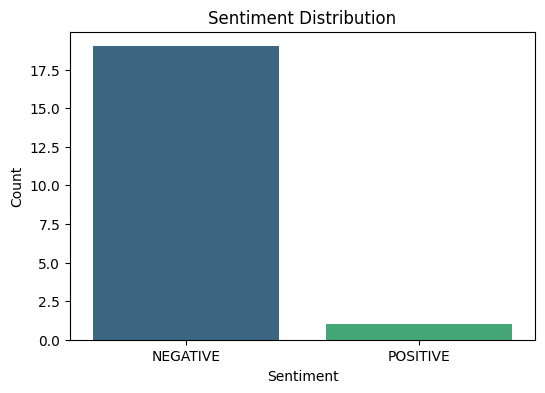

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a count plot for sentiment labels
sentiment_labels = [s['label'] for s in sentiments]
plt.figure(figsize=(6,4))
sns.countplot(x=sentiment_labels, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


#Keyword Extraction (using KeyBERT predefined model)

In [ ]:
# initializes an instance of the KeyBERT model
kw_model = KeyBERT()

# Extract keywords for each cleaned article(extracts the top 5 keywords from each)
keywords = [kw_model.extract_keywords(article, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=5)
            for article in cleaned_articles]

# Create a DataFrame to display the keywords
keywords_df = pd.DataFrame({
    'Keywords': ['; '.join([kw[0] for kw in kw_list]) for kw_list in keywords],
})

# Display the first 10 rows as an HTML table
display(HTML(keywords_df.head(10).to_html(index=False)))


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Keywords
plane seat; plane health; seat standard; haul seat; row seat
lion shout; climb lion; lion mr; kill lion; fortun lion
freedman contract; forest freedman; deal nottingham; freedman replac; doubl freedman
liverpool target; liverpool pari; includ liverpool; liverpool; liverpool pig
speak bruce; bruce; bruce tell; enhanc bruce; bruce venner
pool crew; pool mobil; pool specialist; unit pool; crew firefight
radio listen; listen radio; radio audienc; radio daili; radio
hous reunion; hous stamp; reunion spinou; seri hous; seri netflix
match poverti; poverti sheffield; game poverti; poverti admit; poverti
gang parti; victim parti; victim describ; target gang; rape sentenc


#Keyword Extraction Visualization using Word Clouds visualization

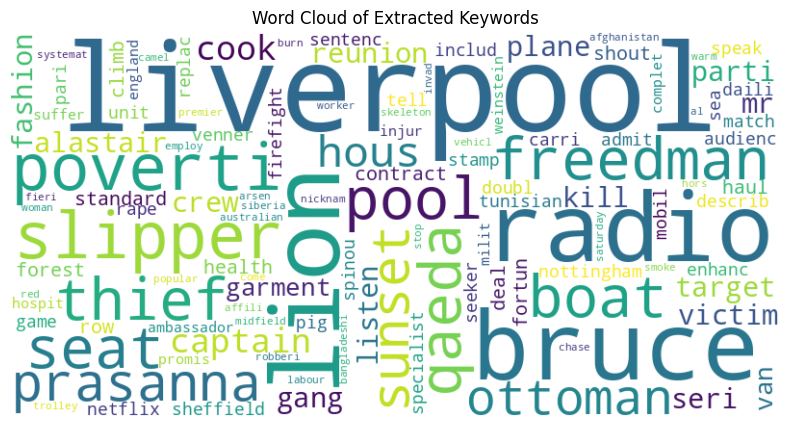

In [ ]:
from wordcloud import WordCloud

# Combine all extracted keywords into one string
all_keywords = ' '.join([kw[0] for kw_list in keywords for kw in kw_list])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_keywords)

# Display the word cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Extracted Keywords')
plt.show()


#Topic Modeling (using Gensim LDA predefined model)

In [ ]:
# Tokenize cleaned articles for LDA input
tokenized_articles = [article.split() for article in cleaned_articles]

# Create a dictionary and corpus for topic modeling
dictionary = corpora.Dictionary(tokenized_articles)
corpus = [dictionary.doc2bow(text) for text in tokenized_articles]

# Train LDA model (set number of topics)
lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)

# Print the topics found in the articles
topics = lda_model.print_topics(num_words=4)
for idx, topic in enumerate(topics, 1):
    print(f"Topic {idx}: {topic}")


Topic 1: (0, '0.010*"year" + 0.008*"rescu" + 0.007*"say" + 0.007*"boat"')
Topic 2: (1, '0.009*"weinstein" + 0.009*"year" + 0.007*"mr" + 0.007*"pakistani"')
Topic 3: (2, '0.010*"say" + 0.007*"camel" + 0.006*"time" + 0.006*"year"')


In [ ]:
# Checks which topic is suitable for each article

# Get the topic distribution for each article
topic_distribution = lda_model.get_document_topics(corpus)

# Assign the dominant topic for each article
dominant_topics = []
for dist in topic_distribution:
    # Get the topic with the highest probability
    dominant_topic = max(dist, key=lambda x: x[1])
    dominant_topics.append(dominant_topic[0])  # Store the topic index

# Create a DataFrame to display articles with their dominant topics
article_topics_df = pd.DataFrame({
    'Article': cleaned_articles,
    'Dominant Topic': dominant_topics
})

# Display the first few rows
print(article_topics_df.head())

                                             Article  Dominant Topic
0  notic plane seat appear get small small increa...               0
1  drunk teenag boy rescu secur jump lion enclosu...               1
2  doubl freedman verg agre new year deal remain ...               1
3  liverpool target net want pig club spain brand...               2
4  bruce venner break silenc hour interview dine ...               2


#Topic Modeling Visualization using pyLDAvis

In [ ]:
# Install pyLDAvis
!pip install pyLDAvis

# Import the necessary functions from pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Prepare the visualization for the LDA model
lda_display = gensimvis.prepare(lda_model, corpus, dictionary)

# Show the visualization
pyLDAvis.display(lda_display)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 21.6 MB/s eta 0:00:00


#Evaluation of Summarization (Using ROUGE Score)

ROUGE-1 : Typical Range:-  0.2–0.4 |
ROUGE-2 : Typical Range:-  Lower than ROUGE-1, generally between 0.1–0.2 |  
ROUGE-L : Typical Range:-  0.2–0.4

In [ ]:
# Initialize ROUGE scorer from the rouge_scorer library
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores for each article
rouge1_scores, rouge2_scores, rougeL_scores = [], [], []
for ref, gen in zip(df['highlights'], summaries):
    scores = scorer.score(ref, gen)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Create a DataFrame to display the ROUGE scores
rouge_df = pd.DataFrame({
    'ROUGE-1': rouge1_scores,
    'ROUGE-2': rouge2_scores,
    'ROUGE-L': rougeL_scores
})

# Display the first 10 rows as an HTML table
display(HTML(rouge_df.head(10).to_html(index=False)))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ROUGE-1,ROUGE-2,ROUGE-L
0.301370,0.084507,0.301370
0.253521,0.115942,0.140845
0.245614,0.036364,0.210526
0.152381,0.000000,0.095238
0.181818,0.018519,0.127273
0.246575,0.056338,0.164384
0.157480,0.000000,0.110236
0.175000,0.051282,0.075000
0.109589,0.000000,0.109589
0.079365,0.000000,0.047619


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


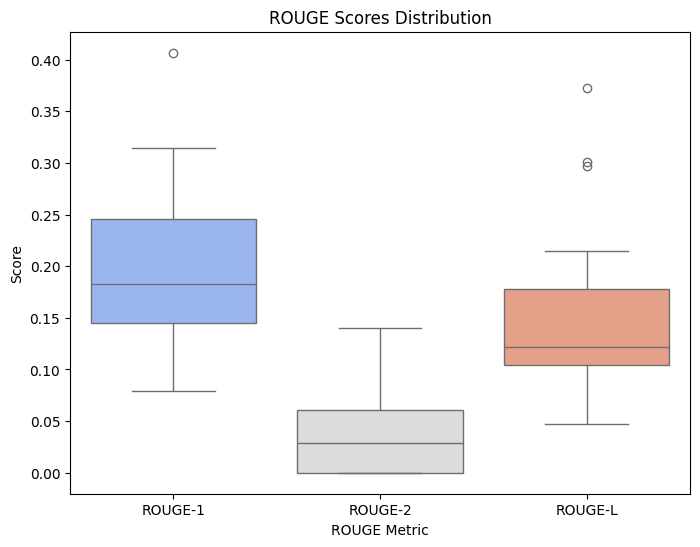

In [ ]:
# Create boxplots for ROUGE scores
plt.figure(figsize=(8,6))
sns.boxplot(data=rouge_df, palette='coolwarm')
plt.title('ROUGE Scores Distribution')
plt.xlabel('ROUGE Metric')
plt.ylabel('Score')
plt.show()

# Performance Evaluation Precision/Recall/F1-score/MAE/RMSE

In [ ]:
# Import necessary libraries
from sklearn.metrics import precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from IPython.display import display, HTML

# Initialize lists to collect metrics
precision_scores, recall_scores, f1_scores, mae_scores, rmse_scores = [], [], [], [], []

# Calculate metrics for each summary
for ref, gen in zip(df['highlights'], summaries):
    # Tokenize summaries into words for Precision, Recall, and F1-score
    gen_tokens = gen.split()
    ref_tokens = ref.split()

    # Calculate Precision, Recall, and F1-score based on tokens
    common_tokens = set(gen_tokens) & set(ref_tokens)
    precision = len(common_tokens) / len(gen_tokens) if gen_tokens else 0
    recall = len(common_tokens) / len(ref_tokens) if ref_tokens else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    # Append metrics to lists
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calculate MAE and RMSE based on summary length differences
    length_diff = abs(len(gen_tokens) - len(ref_tokens))
    mae_scores.append(length_diff)
    rmse_scores.append(length_diff ** 2)

# Calculate average RMSE
avg_rmse = np.sqrt(np.mean(rmse_scores))

# Create a DataFrame to display all metrics
metrics_df = pd.DataFrame({
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1-score': f1_scores,
    'MAE': mae_scores,
    'RMSE': [avg_rmse] * len(precision_scores)  # Display RMSE as a constant value for simplicity
})

# Display the first 10 rows as an HTML table
display(HTML(metrics_df.head(10).to_html(index=False)))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Precision,Recall,F1-score,MAE,RMSE
0.125000,0.138889,0.131579,4,38.618648
0.135135,0.131579,0.133333,1,38.618648
0.115385,0.085714,0.098361,9,38.618648
0.015385,0.022727,0.018349,21,38.618648
0.094340,0.081967,0.087719,8,38.618648
0.161290,0.108696,0.129870,15,38.618648
0.081081,0.032258,0.046154,56,38.618648
0.053571,0.120000,0.074074,31,38.618648
0.111111,0.061224,0.078947,22,38.618648
0.012987,0.017544,0.014925,20,38.618648


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


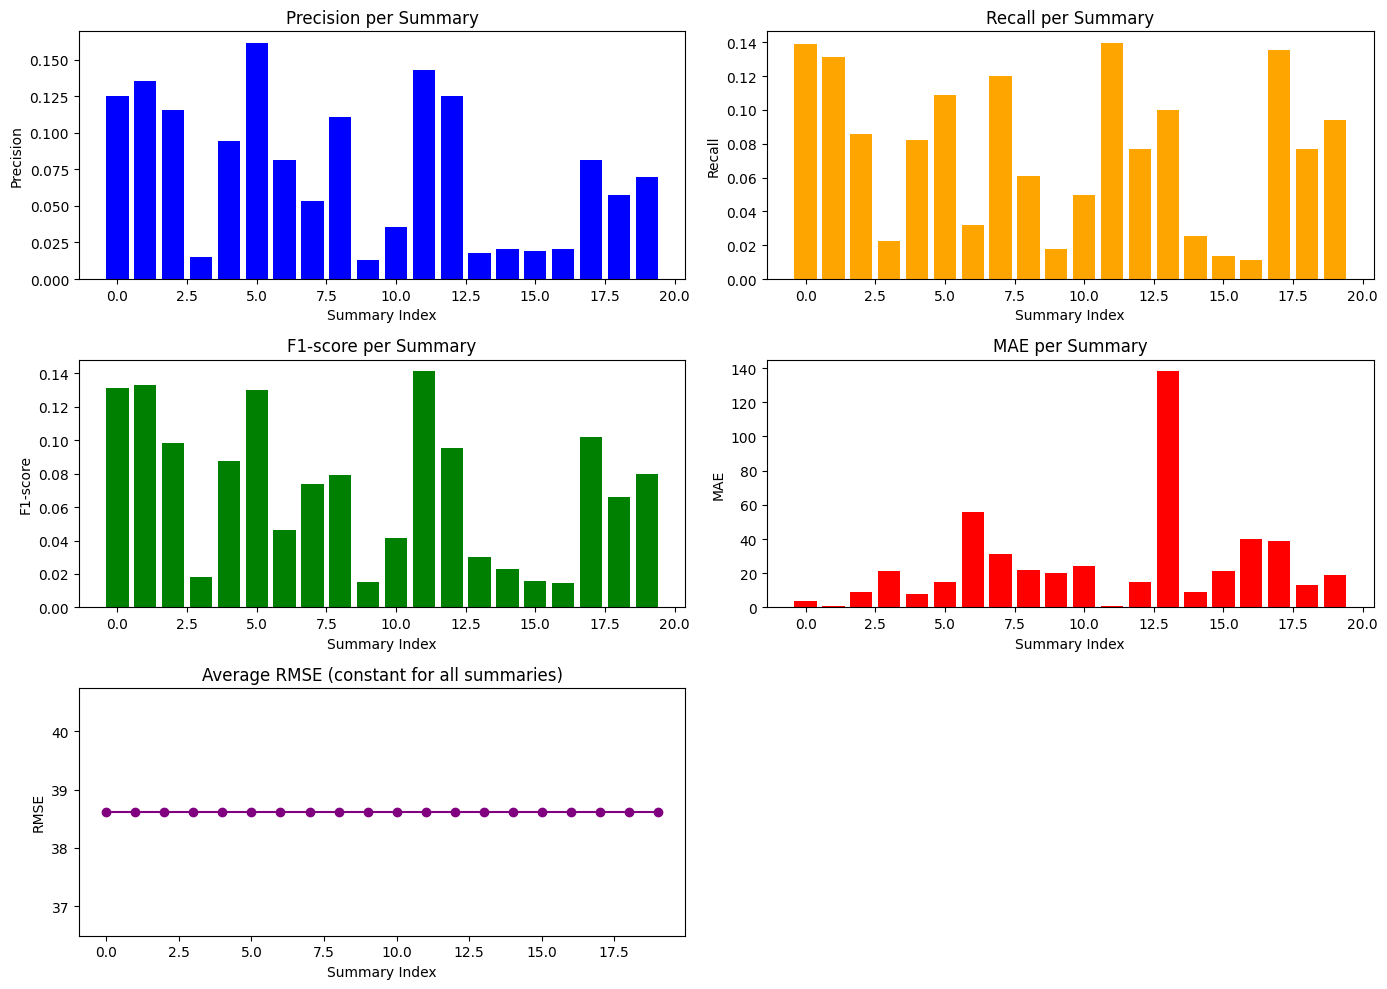

In [ ]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt

# Create a bar plot for each metric
plt.figure(figsize=(14, 10))

# Plot Precision
plt.subplot(3, 2, 1)
plt.bar(range(len(precision_scores)), precision_scores, color='blue')
plt.title('Precision per Summary')
plt.xlabel('Summary Index')
plt.ylabel('Precision')

# Plot Recall
plt.subplot(3, 2, 2)
plt.bar(range(len(recall_scores)), recall_scores, color='orange')
plt.title('Recall per Summary')
plt.xlabel('Summary Index')
plt.ylabel('Recall')

# Plot F1-score
plt.subplot(3, 2, 3)
plt.bar(range(len(f1_scores)), f1_scores, color='green')
plt.title('F1-score per Summary')
plt.xlabel('Summary Index')
plt.ylabel('F1-score')

# Plot MAE
plt.subplot(3, 2, 4)
plt.bar(range(len(mae_scores)), mae_scores, color='red')
plt.title('MAE per Summary')
plt.xlabel('Summary Index')
plt.ylabel('MAE')

# Plot RMSE
plt.subplot(3, 2, 5)
plt.plot([avg_rmse] * len(precision_scores), marker='o', color='purple')
plt.title('Average RMSE (constant for all summaries)')
plt.xlabel('Summary Index')
plt.ylabel('RMSE')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


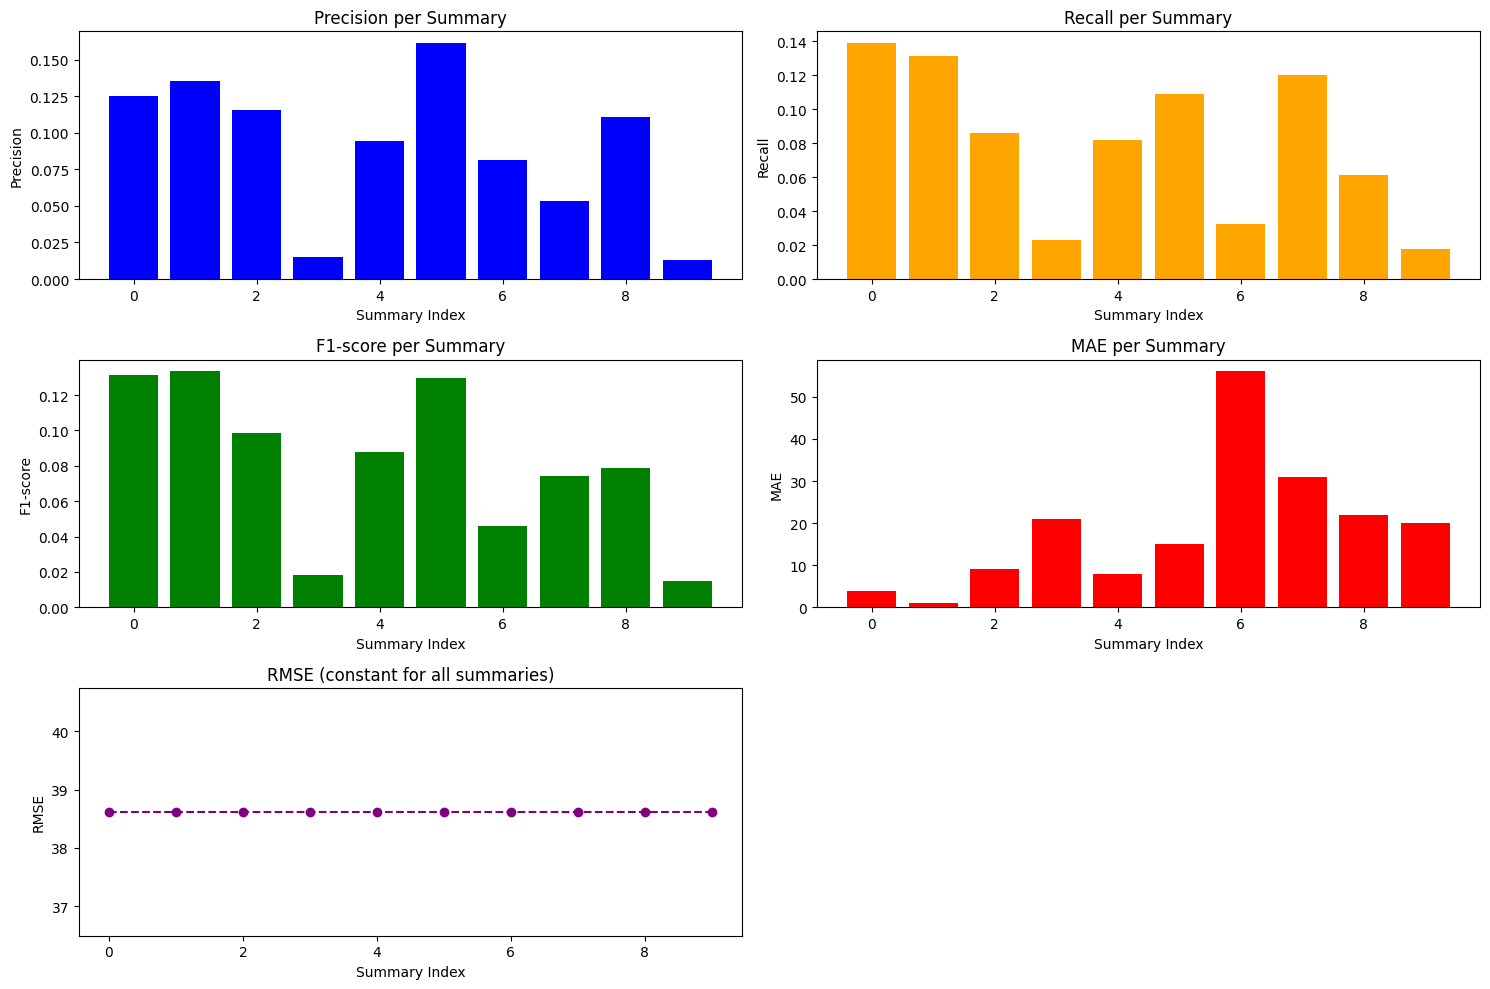

In [ ]:
# Define the plot size
plt.figure(figsize=(15, 10))

# Plot Precision
plt.subplot(3, 2, 1)
plt.bar(metrics_df.index, metrics_df['Precision'], color='blue')
plt.title('Precision per Summary')
plt.xlabel('Summary Index')
plt.ylabel('Precision')

# Plot Recall
plt.subplot(3, 2, 2)
plt.bar(metrics_df.index, metrics_df['Recall'], color='orange')
plt.title('Recall per Summary')
plt.xlabel('Summary Index')
plt.ylabel('Recall')

# Plot F1-score
plt.subplot(3, 2, 3)
plt.bar(metrics_df.index, metrics_df['F1-score'], color='green')
plt.title('F1-score per Summary')
plt.xlabel('Summary Index')
plt.ylabel('F1-score')

# Plot MAE
plt.subplot(3, 2, 4)
plt.bar(metrics_df.index, metrics_df['MAE'], color='red')
plt.title('MAE per Summary')
plt.xlabel('Summary Index')
plt.ylabel('MAE')

# Plot RMSE as a constant line
plt.subplot(3, 2, 5)
plt.plot(metrics_df.index, metrics_df['RMSE'], marker='o', color='purple', linestyle='--')
plt.title('RMSE (constant for all summaries)')
plt.xlabel('Summary Index')
plt.ylabel('RMSE')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
